In [ ]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/WSN-DS.csv'
data = pd.read_csv(file_path)

# Separate features and labels
X = data.drop(columns=['Attack type'])
y = data['Attack type']

# Convert the features to text format (assuming the features are numerical and need conversion)
X_text = X.astype(str).apply(lambda x: ' '.join(x), axis=1)

In [ ]:
# Apply the transformation to 'Attack type'
data['Attack type'] = data['Attack type'].apply(lambda x: 0 if x == 'Normal' else 1)

# Display the first few rows to verify the transformation
data['Attack type'].value_counts()


,count
Attack type,
0,340066
1,34595


In [ ]:
data['Attack type'].head()

,Attack type
0,0
1,0
2,0
3,0
4,0


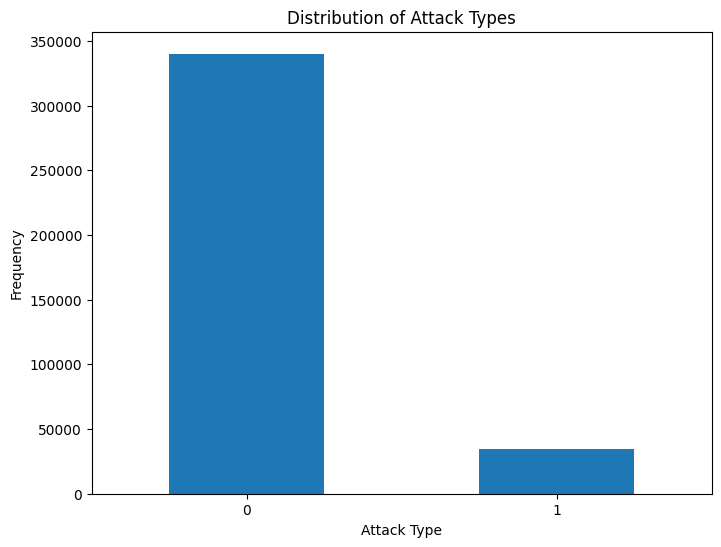

In [ ]:
# prompt: plots of data['attack type']

# Count the occurrences of each attack type
attack_type_counts = data['Attack type'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
attack_type_counts.plot(kind='bar')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Separate majority and minority classes
normal_data = data[data['Attack type'] == 0]
attack_data = data[data['Attack type'] == 1]

# Undersample the majority class
normal_undersampled = resample(normal_data,
                               replace=False,    # sample without replacement
                               n_samples=len(attack_data) * 2, # to keep the ratio as 2:1
                               random_state=42)  # for reproducibility
# Combine the remaining normal_data with attack_data
balanced_data = pd.concat([normal_undersampled, attack_data])
# Combine the undersampled majority class with the minority class
balanced_distribution = balanced_data['Attack type'].value_counts()

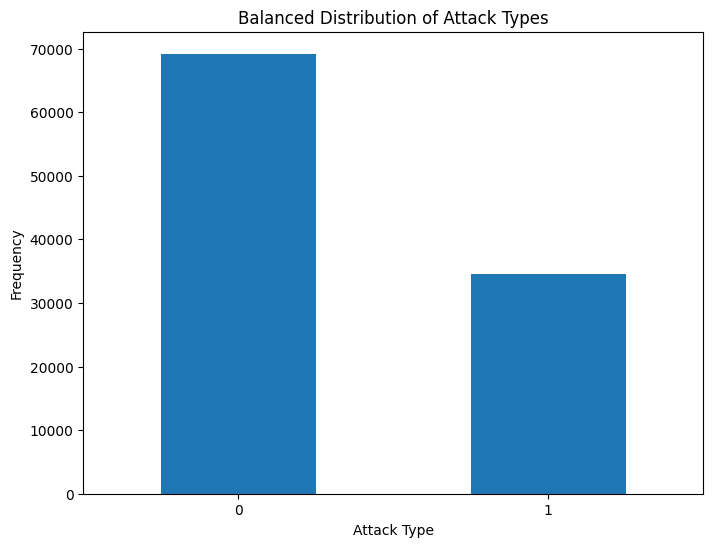

In [ ]:
plt.figure(figsize=(8, 6))
balanced_distribution.plot(kind='bar')
plt.title('Balanced Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset

# Separate features and labels from the balanced dataset
# Separate features and labels from the balanced dataset
X = balanced_data.drop(columns=['Attack type']).astype(str).apply(lambda x: ' '.join(x), axis=1)
y = balanced_data['Attack type']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert X_train and X_test to lists of strings
X_train = X_train.tolist()
X_test = X_test.tolist()

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_data(data):
    return tokenizer(
        data,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Tokenize the training and test sets
X_train_tokens = tokenize_data(X_train)
X_test_tokens = tokenize_data(X_test)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train_tokens['input_ids'], X_train_tokens['attention_mask'], y_train_tensor)
test_dataset = TensorDataset(X_test_tokens['input_ids'], X_test_tokens['attention_mask'], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from transformers import BertForSequenceClassification

# Load the pre-trained BERT model for binary classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

Epoch 1, Train Loss: 0.05746923269572092, Validation Loss: 0.04798668684676083
Epoch 2, Train Loss: 0.039458873433999446, Validation Loss: 0.037236701133420605
Epoch 3, Train Loss: 0.03567252237460108, Validation Loss: 0.034110051506229075


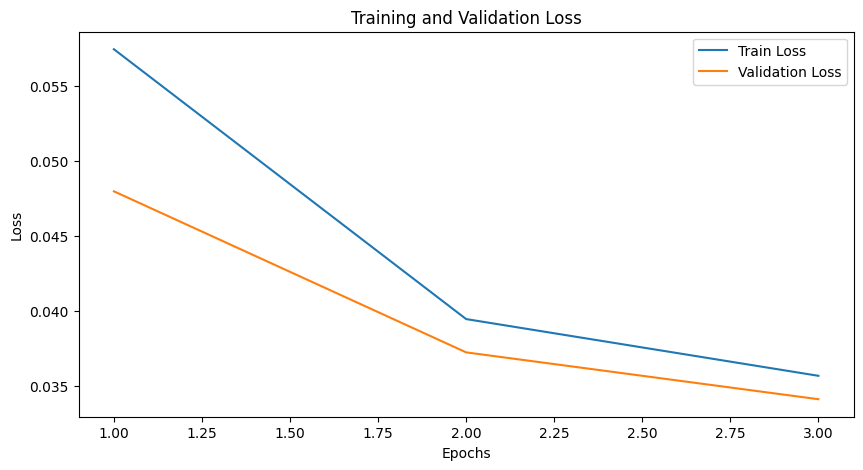

In [ ]:
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns

# Evaluate the model
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        y_true.extend(labels.tolist())
        y_pred_batch = torch.argmax(logits, dim=1).tolist()
        y_pred.extend(y_pred_batch)
        y_scores.extend(torch.softmax(logits, dim=1)[:, 1].tolist())

print(f'Classification Report:\n{classification_report(y_true, y_pred)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13919
           1       0.99      0.99      0.99      6838

    accuracy                           0.99     20757
   macro avg       0.99      0.99      0.99     20757
weighted avg       0.99      0.99      0.99     20757



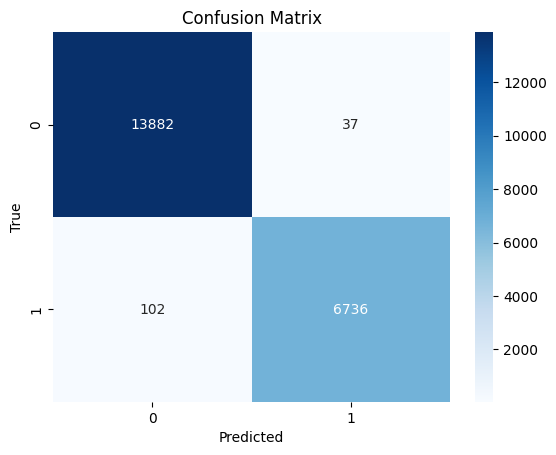

In [ ]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix')

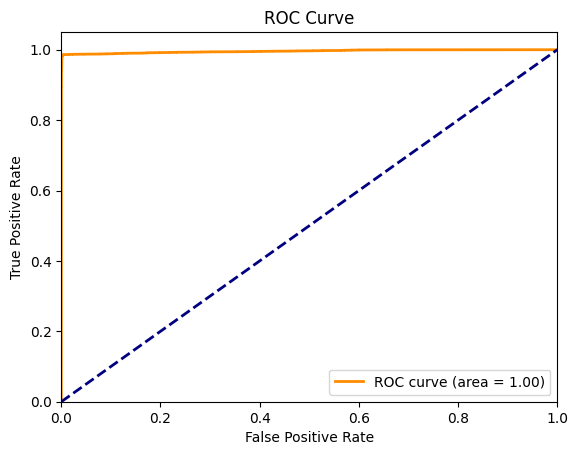

In [ ]:
# ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_true, y_scores, 'ROC Curve')

In [ ]:
from transformers import DistilBertForSequenceClassification

# Load the smaller DistilBERT model for binary classification
student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
student_model.to(device)

# Define the distillation loss
def distillation_loss(student_outputs, teacher_outputs, labels, temperature=2.0, alpha=0.5):
    student_loss = torch.nn.functional.cross_entropy(student_outputs.logits, labels)
    teacher_probs = torch.nn.functional.softmax(teacher_outputs.logits / temperature, dim=-1)
    student_log_probs = torch.nn.functional.log_softmax(student_outputs.logits / temperature, dim=-1)
    distillation_loss = torch.nn.functional.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (temperature ** 2)
    return alpha * student_loss + (1 - alpha) * distillation_loss

# Training loop for the student model
optimizer = torch.optim.AdamW(student_model.parameters(), lr=2e-5)
student_model.train()

for epoch in range(3):  # Number of epochs
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        with torch.no_grad():
            teacher_outputs = model(input_ids, attention_mask=attention_mask)
        student_outputs = student_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = distillation_loss(student_outputs, teacher_outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.001339321956038475
Epoch 2, Loss: 0.0036112922243773937
Epoch 3, Loss: 0.00798217486590147


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
            true_labels.extend(labels.tolist())
    return accuracy_score(true_labels, preds), classification_report(true_labels, preds)

# Evaluate the teacher model
teacher_acc, teacher_report = evaluate(model, test_loader)
print(f'Teacher Model Accuracy: {teacher_acc}')
print(f'Teacher Model Classification Report:\n{teacher_report}')

# Evaluate the student model
student_acc, student_report = evaluate(student_model, test_loader)
print(f'Student Model Accuracy: {student_acc}')
print(f'Student Model Classification Report:\n{student_report}')

Teacher Model Accuracy: 0.9933034638916992
Teacher Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13919
           1       0.99      0.99      0.99      6838

    accuracy                           0.99     20757
   macro avg       0.99      0.99      0.99     20757
weighted avg       0.99      0.99      0.99     20757

Student Model Accuracy: 0.9921954039601099
Student Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13919
           1       0.99      0.98      0.99      6838

    accuracy                           0.99     20757
   macro avg       0.99      0.99      0.99     20757
weighted avg       0.99      0.99      0.99     20757



Epoch 1, Train Loss: 0.019056317777738967, Validation Loss: 0.03417928352116468
Epoch 2, Train Loss: 0.017647649171129175, Validation Loss: 0.036013770007730345
Epoch 3, Train Loss: 0.01856550185556249, Validation Loss: 0.03437158813142578


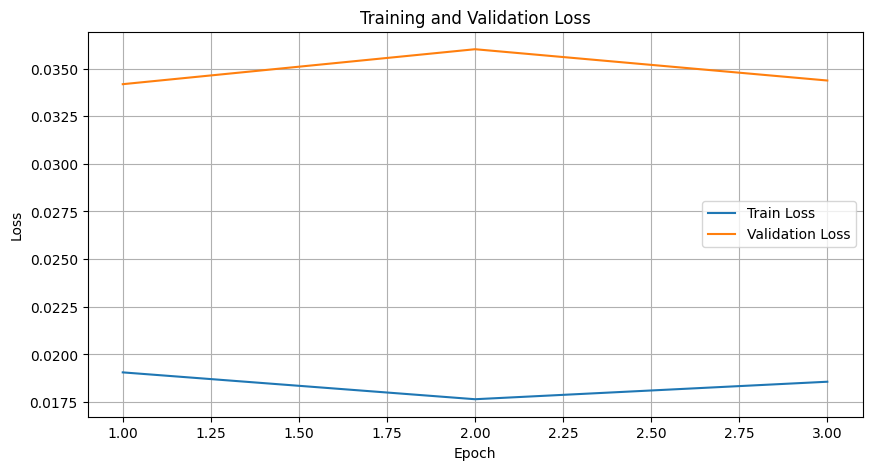

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop for the student model
optimizer = torch.optim.AdamW(student_model.parameters(), lr=2e-5)
student_model.train()

for epoch in range(3):  # Number of epochs
    total_train_loss = 0
    total_val_loss = 0

    # Training phase
    student_model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs = model(input_ids, attention_mask=attention_mask)

        student_outputs = student_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = distillation_loss(student_outputs, teacher_outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    student_model.eval()
    with torch.no_grad():
        for batch in test_loader:  # Assuming you have a validation DataLoader named val_loader
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            student_outputs = student_model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = torch.nn.functional.cross_entropy(student_outputs.logits, labels)

            total_val_loss += val_loss.item()

    # Average validation loss for this epoch
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


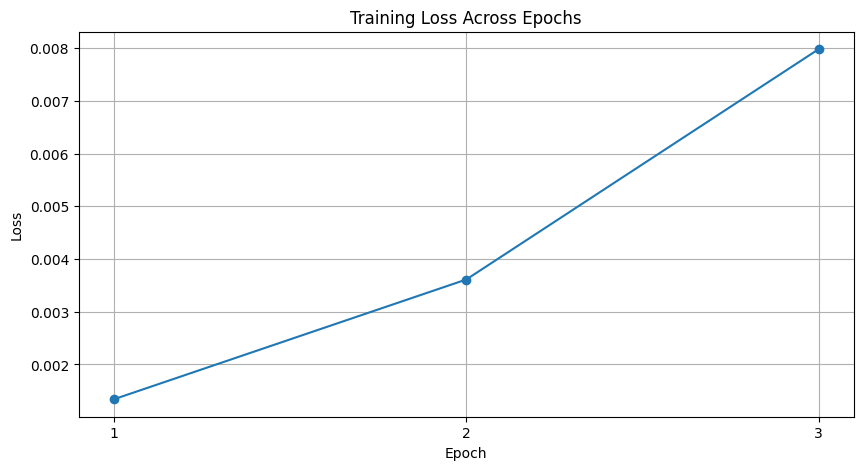

In [ ]:
import matplotlib.pyplot as plt

# Replace this with your actual loss values
losses = [0.001339321956038475, 0.0036112922243773937, 0.00798217486590147]  # Example loss values

# Plotting the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.xticks(range(1, len(losses) + 1))
plt.grid(True)
plt.show()


In [ ]:
# Evaluate the student model and get predictions
student_model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = student_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        y_true.extend(labels.tolist())
        y_pred_batch = torch.argmax(logits, dim=1).tolist()
        y_pred.extend(y_pred_batch)
        y_scores.extend(torch.softmax(logits, dim=1)[:, 1].tolist())

# Print the classification report for the student model
print(f'Student Model Classification Report:\n{classification_report(y_true, y_pred)}')

Student Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13919
           1       0.99      0.98      0.99      6838

    accuracy                           0.99     20757
   macro avg       0.99      0.99      0.99     20757
weighted avg       0.99      0.99      0.99     20757



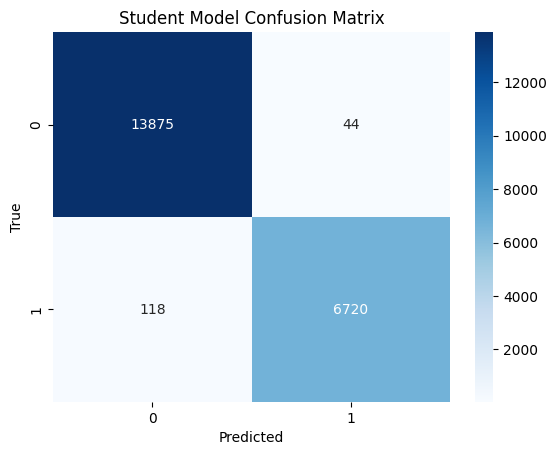

In [ ]:
# Confusion matrix function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrix for the student model
plot_confusion_matrix(y_true, y_pred, 'Student Model Confusion Matrix')

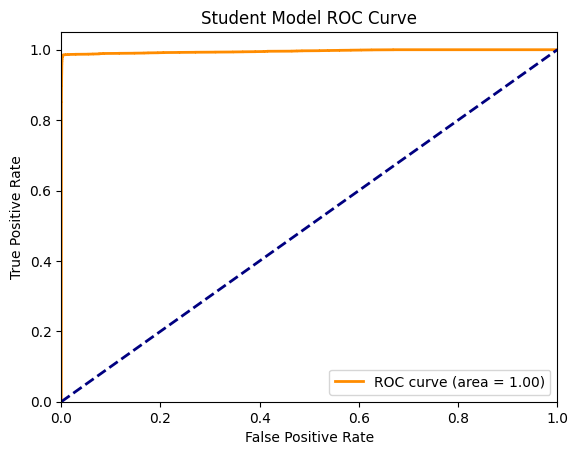

In [ ]:
# ROC curve function
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for the student model
plot_roc_curve(y_true, y_scores, 'Student Model ROC Curve')